In [30]:
from tau_profile_parser import TauProfileParser
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly as py
import plotly.express as px
pd.options.plotting.backend = "plotly"

In [31]:
path_to_ExampleData = '/home/users/MTrappett/tau2/examples/jupyter_notebooks/ExampleData'

In [32]:
orig = TauProfileParser.parse(path_to_ExampleData+'/theta_64_flash/orig',MULTI=True)
nc_static = TauProfileParser.parse(path_to_ExampleData+'/theta_64_flash/nocall_static',MULTI=True)
nocall = TauProfileParser.parse(path_to_ExampleData+'/theta_64_flash/nocall',MULTI=True)

Saving the dataframes from a tau profile object

In [33]:
orig_df = orig.interval_data()
nc_static_df = nc_static.interval_data()
nocall_df = nocall.interval_data()

The DF has a multilevel index and column which can be helpful, but also difficult to work with.

In [34]:
nocall_df.head(2)

Intervals                                        Calls Subcalls ProfileCalls  \
Metric                                                                         
Node Context Thread Timer                                                      
0    0       0      *** custom:Driver_computeDt    233      699            0   
                    *** custom:Gravity potential   233        0            0   

Intervals                                                       Group  \
Metric                                                                  
Node Context Thread Timer                                               
0    0       0      *** custom:Driver_computeDt   GROUP="TAU_DEFAULT"   
                    *** custom:Gravity potential  GROUP="TAU_DEFAULT"   

Intervals                                                           Timer Name  \
Metric                                                                           
Node Context Thread Timer                                                        
0    0       0      *** custom:Driver_computeDt    *** custom:Driver_computeDt   
                    *** custom:Gravity potential  *** custom:Gravity potential   

Intervals                                        Timer Location Timer Type  \
Metric                                                                       
Node Context Thread Timer                                                    
0    0       0      *** custom:Driver_computeDt            None       None   
                    *** custom:Gravity potential           None       None   

Intervals                                            Exclusive              \
Metric                                            PAPI_TOT_INS PAPI_L1_DCM   
Node Context Thread Timer                                                    
0    0       0      *** custom:Driver_computeDt   1.031790e+09  15060056.0   
                    *** custom:Gravity potential  9.679000e+05     10067.0   

Intervals                                                                 \
Metric                                           PAPI_RES_STL       TIME   
Node Context Thread Timer                                                  
0    0       0      *** custom:Driver_computeDt    56647140.0  1908904.0   
                    *** custom:Gravity potential      37448.0     1991.0   

Intervals                                            Inclusive              \
Metric                                            PAPI_TOT_INS PAPI_L1_DCM   
Node Context Thread Timer                                                    
0    0       0      *** custom:Driver_computeDt   6.520803e+09  17389320.0   
                    *** custom:Gravity potential  9.679000e+05     10067.0   

Intervals                                                                   
Metric                                            PAPI_RES_STL        TIME  
Node Context Thread Timer                                                   
0    0       0      *** custom:Driver_computeDt   3.689970e+09  11487217.0  
                    *** custom:Gravity potential  3.744800e+04      1991.0

In [35]:
# num of nodes, 1 based indexing
nodes_num = 10
# for exclusive, time
orig_time = pd.DataFrame()
nc_static_time = pd.DataFrame()
nocall_time = pd.DataFrame()
for node in range(nodes_num):
    orig_time = orig_time.append(orig_df.loc[(node,0,0),('Exclusive','TIME')].T)
    nc_static_time = nc_static_time.append(nc_static_df.loc[(node,0,0),('Exclusive','TIME')].T)
    nocall_time = nocall_time.append(nocall_df.loc[(node,0,0),('Exclusive','TIME')].T)            

In [36]:
# sort the timers by Exclusive, TIME
orig_sums = orig_time.sum()
orig_sums.sort_values(ascending=False, inplace=True)

# drop the MPI TIMERS
for timer in orig_sums.index:
    if 'MPI' in timer:
#         print(timer)
        orig_sums.drop(labels=timer, inplace=True)

# the top timers
orig_top = orig_sums.head(6)
top_timers = [timer for timer in orig_top.index]

In [37]:
orig_time.reset_index(drop=True, inplace=True)
nc_static_time.reset_index(drop=True, inplace=True)
nocall_time.reset_index(drop=True, inplace=True)

In [38]:
orig_time.index

RangeIndex(start=0, stop=10, step=1)

In [39]:
# normalize: top_diff = ((top_diff - top_diff.min())/(top_diff.max() - top_diff.min()))

orig_time_norm = ((orig_time - orig_time.min())/(orig_time.max() - orig_time.min()))
orig_time_norm['Node'] = orig_time_norm.index
orig_time_norm['Method'] = ['Orig' for i in range(nodes_num)]

nc_static_time_norm = ((nc_static_time - nc_static_time.min())/(nc_static_time.max() - nc_static_time.min()))
nc_static_time_norm['Node'] = nc_static_time_norm.index
nc_static_time_norm['Method'] = ['Static' for i in range(nodes_num)]

nocall_time_norm = ((nocall_time - nocall_time.min())/(nocall_time.max() - nocall_time.min()))
nocall_time_norm['Node'] = nocall_time_norm.index
nocall_time_norm['Method'] = ['NoCall' for i in range(nodes_num)]
# nocall_time_norm.sample(5)

### add the method to the orig_time data frames to plot non-normalized dataframes

In [40]:
orig_time['Node'] = orig_time.index
orig_time['Method'] = ['Orig' for i in range(nodes_num)]

nc_static_time['Node'] = nc_static_time.index
nc_static_time['Method'] = ['Static' for i in range(nodes_num)]

nocall_time['Node'] = nocall_time.index
nocall_time['Method'] = ['NoCall' for i in range(nodes_num)]

In [41]:
total_df = pd.concat([orig_time_norm, nc_static_time_norm, nocall_time_norm])
non_normal_df = pd.concat([orig_time, nc_static_time, nocall_time])


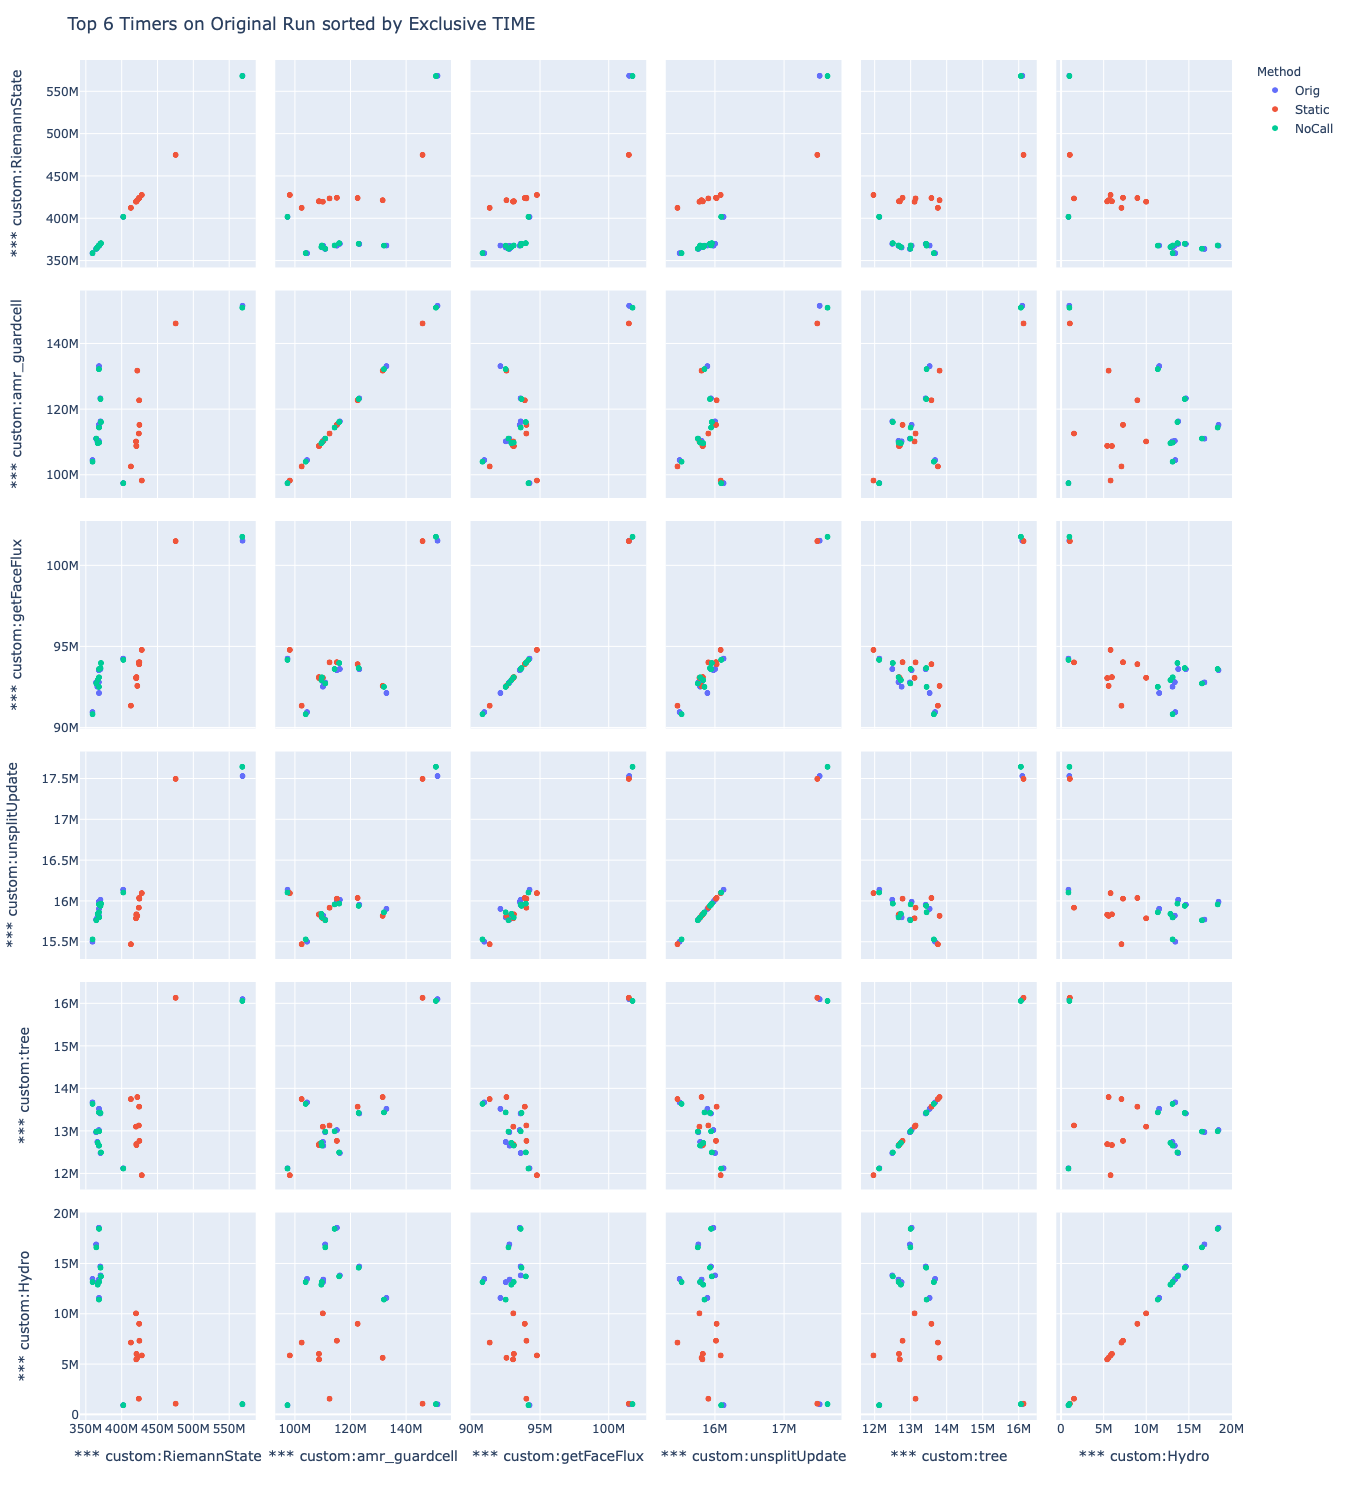

In [42]:
pd.options.plotting.backend = "plotly"


title = 'Top 6 Timers on Original Run sorted by Exclusive TIME'

fig = px.scatter_matrix(non_normal_df, dimensions=top_timers, color='Method', hover_data=['Node'])
fig.update_layout(height=1500, width=1500, title=title)
# fig.write_html("/home/users/MTrappett/Flash5_theta/splom_orig_nocall_noMPI_non_norm.html")

fig.show()

### Non-normalized papi sploms


In [43]:
orig_ins = pd.DataFrame()
nc_static_ins = pd.DataFrame()
nocall_ins = pd.DataFrame()
for node in range(nodes_num):
    orig_ins = orig_ins.append(orig_df.loc[(node,0,0),('Exclusive','PAPI_TOT_INS')].T)
    nc_static_ins = nc_static_ins.append(nc_static_df.loc[(node,0,0),('Exclusive','PAPI_TOT_INS')].T)
    nocall_ins = nocall_ins.append(nocall_df.loc[(node,0,0),('Exclusive','PAPI_TOT_INS')].T) 

# reset index to make it not a multi-index
orig_ins.reset_index(drop=True, inplace=True)
nc_static_ins.reset_index(drop=True, inplace=True)
nocall_ins.reset_index(drop=True, inplace=True)

# add in the node and type columns
orig_ins['Node'] = orig_ins.index
orig_ins['Method'] = ['Orig' for i in range(nodes_num)]

nc_static_ins['Node'] = nc_static_ins.index
nc_static_ins['Method'] = ['Static' for i in range(nodes_num)]

nocall_ins['Node'] = nocall_ins.index
nocall_ins['Method'] = ['NoCall' for i in range(nodes_num)]

non_normal_ins_df = pd.concat([orig_ins, nc_static_ins, nocall_ins])

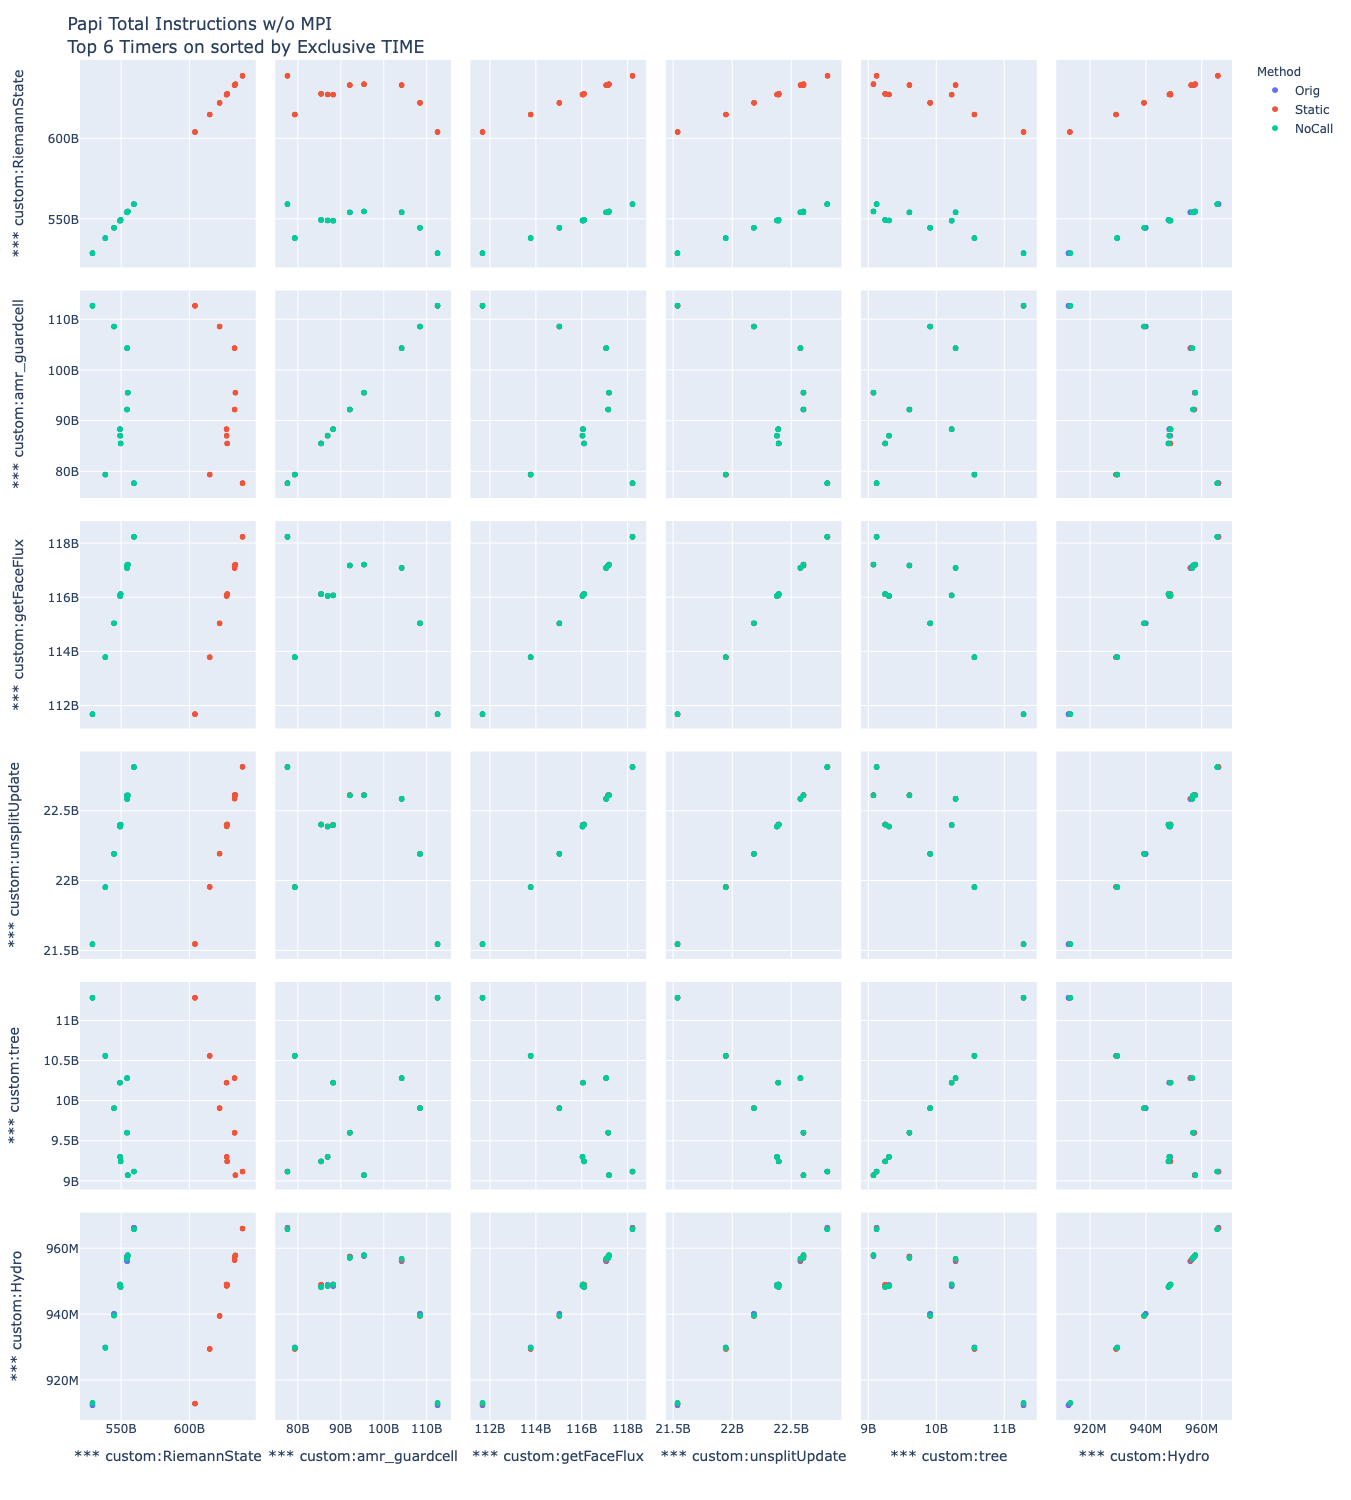

In [44]:
title = 'Papi Total Instructions w/o MPI <br> Top 6 Timers on sorted by Exclusive TIME'

fig = px.scatter_matrix(non_normal_ins_df, dimensions=top_timers, color='Method', hover_data=['Node'], size_max=10)
fig.update_layout(height=1500, width=1500, title=title)
# fig.write_html("/home/users/MTrappett/Flash5_theta/splom_tot_ins_noMPI_non_norm.html")

fig.show()

#### DCM SPLOM

In [45]:
orig_ins = pd.DataFrame()
nc_static_ins = pd.DataFrame()
nocall_ins = pd.DataFrame()
for node in range(nodes_num):
    orig_ins = orig_ins.append(orig_df.loc[(node,0,0),('Exclusive','PAPI_L1_DCM')].T)
    nc_static_ins = nc_static_ins.append(nc_static_df.loc[(node,0,0),('Exclusive','PAPI_L1_DCM')].T)
    nocall_ins = nocall_ins.append(nocall_df.loc[(node,0,0),('Exclusive','PAPI_L1_DCM')].T) 

# reset index to make it not a multi-index
orig_ins.reset_index(drop=True, inplace=True)
nc_static_ins.reset_index(drop=True, inplace=True)
nocall_ins.reset_index(drop=True, inplace=True)

# add in the node and type columns
orig_ins['Node'] = orig_ins.index
orig_ins['Method'] = ['Orig' for i in range(nodes_num)]

nc_static_ins['Node'] = nc_static_ins.index
nc_static_ins['Method'] = ['Static' for i in range(nodes_num)]

nocall_ins['Node'] = nocall_ins.index
nocall_ins['Method'] = ['NoCall' for i in range(nodes_num)]

non_normal_ins_df = pd.concat([orig_ins, nc_static_ins, nocall_ins])

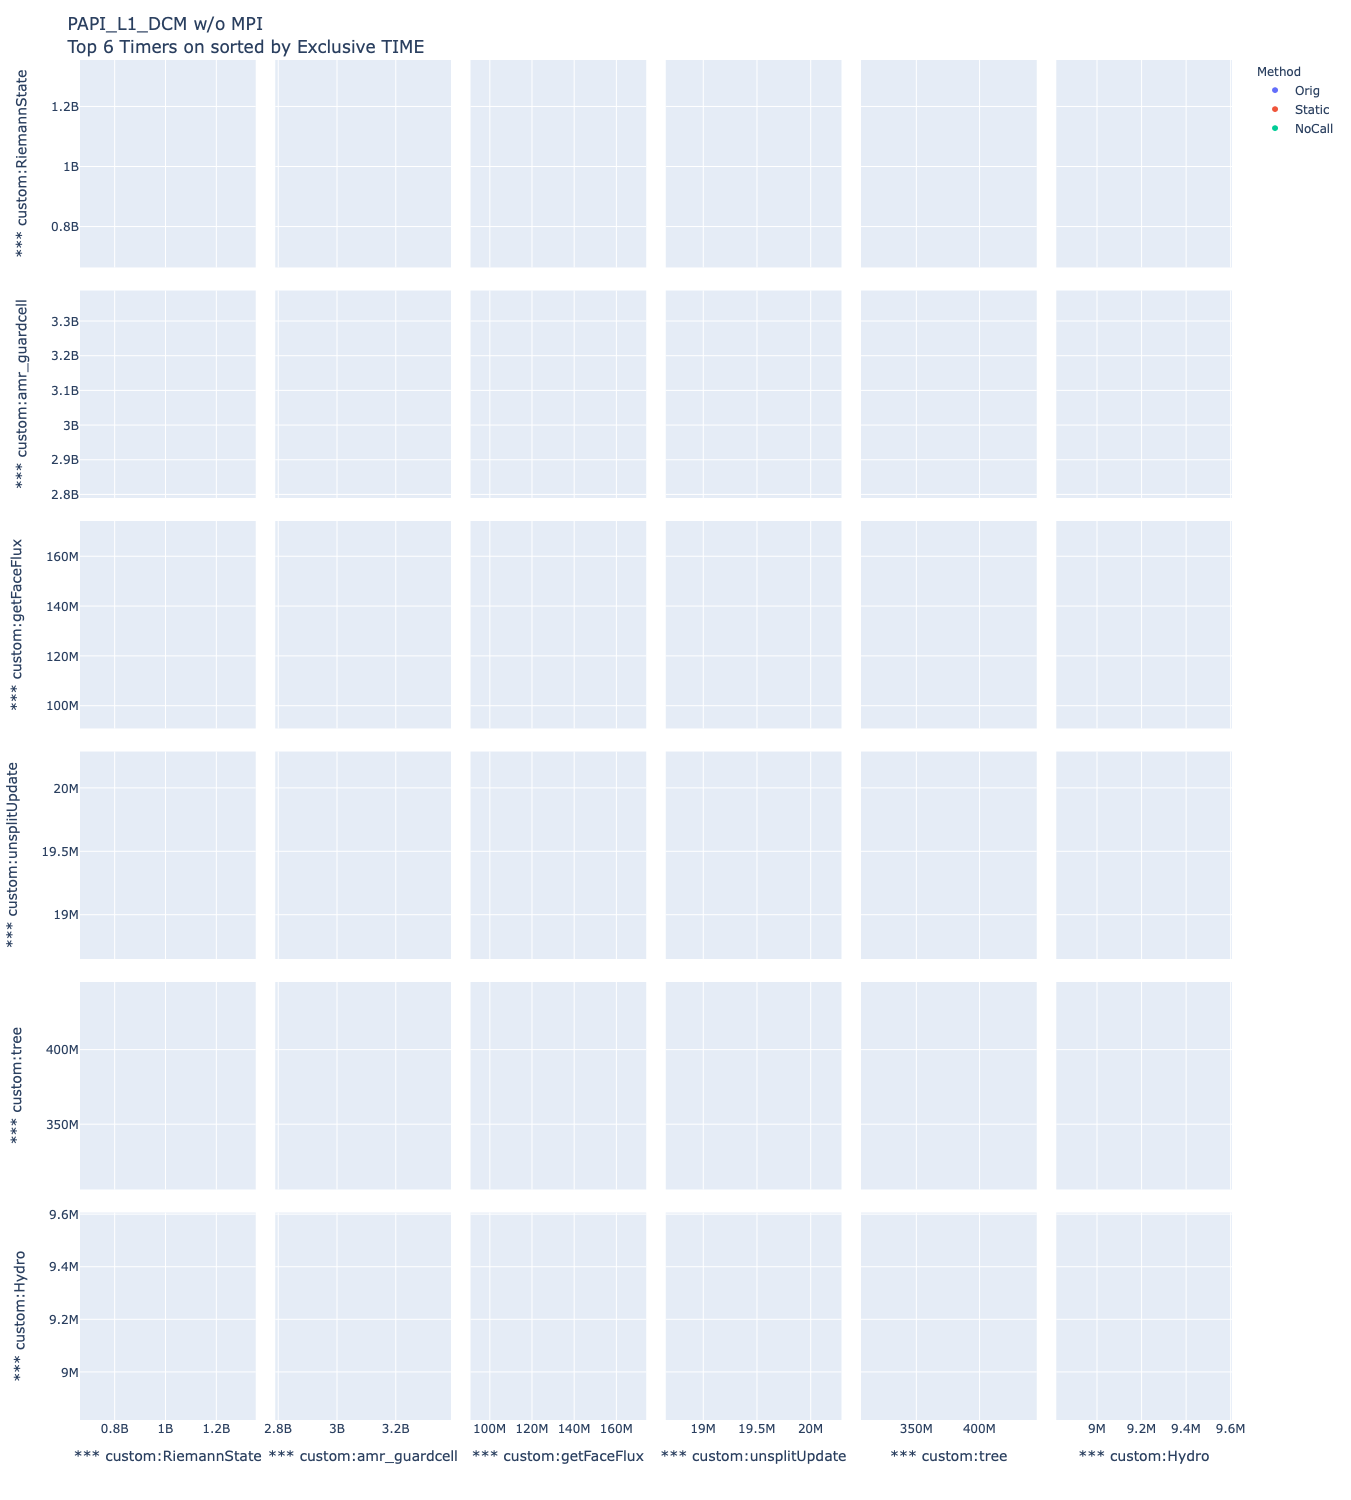

In [46]:
title = 'PAPI_L1_DCM w/o MPI <br> Top 6 Timers on sorted by Exclusive TIME'

fig = px.scatter_matrix(non_normal_ins_df, dimensions=top_timers, color='Method', hover_data=['Node'], size_max=10)
fig.update_layout(height=1500, width=1500, title=title)
# fig.write_html("/home/users/MTrappett/Flash5_theta/splom_l1_DCM_noMPI_non_norm.html")

fig.show()

#### RES STL SPLOM

In [47]:
orig_ins = pd.DataFrame()
nc_static_ins = pd.DataFrame()
nocall_ins = pd.DataFrame()
for node in range(nodes_num):
    orig_ins = orig_ins.append(orig_df.loc[(node,0,0),('Exclusive','PAPI_RES_STL')].T)
    nc_static_ins = nc_static_ins.append(nc_static_df.loc[(node,0,0),('Exclusive','PAPI_RES_STL')].T)
    nocall_ins = nocall_ins.append(nocall_df.loc[(node,0,0),('Exclusive','PAPI_RES_STL')].T) 

# reset index to make it not a multi-index
orig_ins.reset_index(drop=True, inplace=True)
nc_static_ins.reset_index(drop=True, inplace=True)
nocall_ins.reset_index(drop=True, inplace=True)

# add in the node and type columns
orig_ins['Node'] = orig_ins.index
orig_ins['Method'] = ['Orig' for i in range(nodes_num)]

nc_static_ins['Node'] = nc_static_ins.index
nc_static_ins['Method'] = ['Static' for i in range(nodes_num)]

nocall_ins['Node'] = nocall_ins.index
nocall_ins['Method'] = ['NoCall' for i in range(nodes_num)]

non_normal_ins_df = pd.concat([orig_ins, nc_static_ins, nocall_ins])

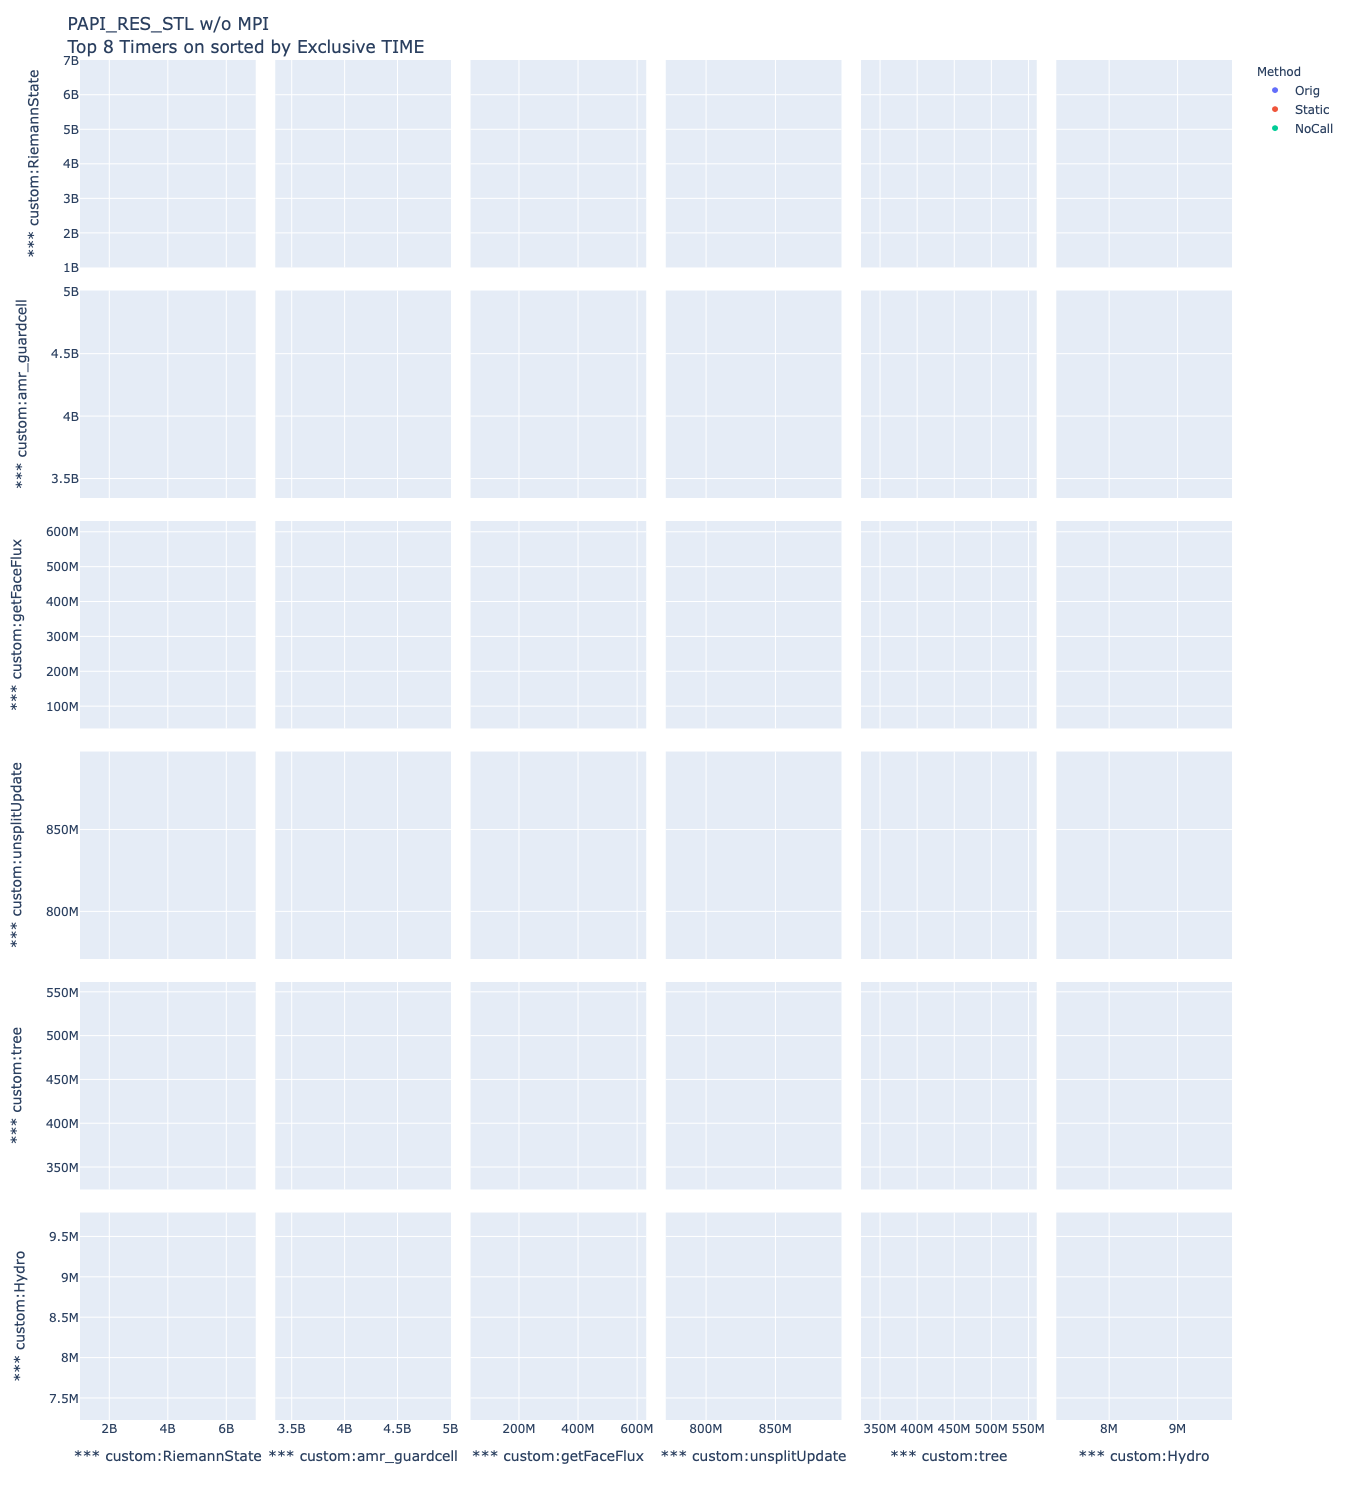

In [48]:
title = 'PAPI_RES_STL w/o MPI <br> Top 8 Timers on sorted by Exclusive TIME'

fig = px.scatter_matrix(non_normal_ins_df, dimensions=top_timers, color='Method', hover_data=['Node'], size_max=10)
fig.update_layout(height=1500, width=1500, title=title)
# fig.write_html("/home/users/MTrappett/Flash5_theta/splom_res_stl_noMPI_non_norm.html")

fig.show()